In [1]:
spark

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 25, 6, Finished, Available)

## Loading Data

In [66]:
%%configure -f \
{"conf": {"spark.jars.packages": "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.2"}}

StatementMeta(, , , SessionStarting, )

Unrecognized options: 

In [ ]:
!pip install spark-nlp
!pip install pyspark

StatementMeta(, , , Waiting, )

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF
from pyspark.ml import Pipeline

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 26, 24, Finished, Available)

In [ ]:
## Necessary Libraries
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline


StatementMeta(, , , Waiting, )

In [5]:
workspace_default_storage_account = "aml6214727930"
workspace_default_container = "azureml-blobstore-6653633b-3460-4381-9199-d9e0f368353c"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)

comments_path = "/basketball_comments_clean.parquet"
submissions_path = "/basketball_submissions_clean.parquet"

comments = spark.read.parquet(f"{workspace_wasbs_base_url}{comments_path}")
submissions = spark.read.parquet(f"{workspace_wasbs_base_url}{submissions_path}")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 26, 6, Finished, Available)

## NLP Processing

### Part 1: Data Checks

##### Most Common Words

In [17]:
comments = comments.cache()
submissions = submissions.cache()

# find the top 10 most common words in comments without cleaning
words = comments.select(explode(split(comments["body"], "\s+")).alias("word")) # split the body column in words
word_counts = words.groupBy("word").count() # group by each word and count
top_10_words = word_counts.orderBy(desc("count")).limit(10) # sort the words and take top 10
print("Top 10 Words in Comments")
top_10_words.show()

# find the top 10 most common words in submissions without cleaning
words = submissions.select(explode(split(submissions["selftext"], "\s+")).alias("word")) # split the body column in words
word_counts = words.groupBy("word").count() # group by each word and count
top_10_words = word_counts.orderBy(desc("count")).limit(10) # sort the words and take top 10
print("Top 10 Words in Submissions")
top_10_words.show()

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 26, 18, Finished, Available)

Top 10 Words in Comments
+----+------+
|word| count|
+----+------+
| the|958778|
|   a|599649|
|  to|552908|
| and|399550|
|   I|386791|
|  in|338734|
|  is|333757|
|  of|330328|
|that|262082|
| for|218723|
+----+------+

Top 10 Words in Submissions
+--------------------+------+
|                word| count|
+--------------------+------+
|                   ||235602|
|                   -| 23506|
|                 the| 23140|
|                  to| 15876|
|                   a| 14834|
|-----------------...| 12805|
|                  of| 10815|
|                 and| 10239|
|                  on|  9514|
|                team|  7621|
+--------------------+------+



##### Distribution of Text Lengths

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 26, 21, Finished, Available)

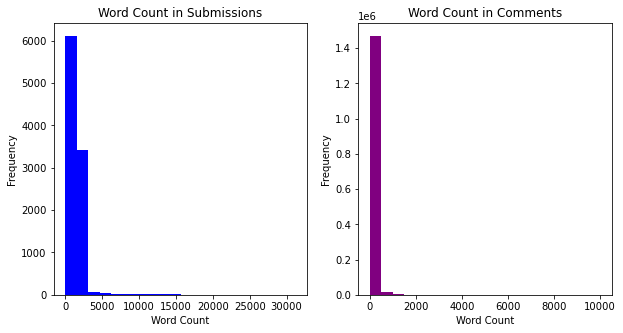

In [20]:
submissions_l = submissions.withColumn("selftext_word_count", length(col("selftext")))
comments_l = comments.withColumn("body_word_count", length(col("body")))

selftext_word_count = submissions_l.select("selftext_word_count").rdd.flatMap(lambda x: x).collect()
body_word_count = comments_l.select("body_word_count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(selftext_word_count, bins=20, color='blue')
plt.title('Word Count in Submissions')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(body_word_count, bins=20, color='purple')
plt.title('Word Count in Comments')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.show()

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 26, 19, Finished, Available)

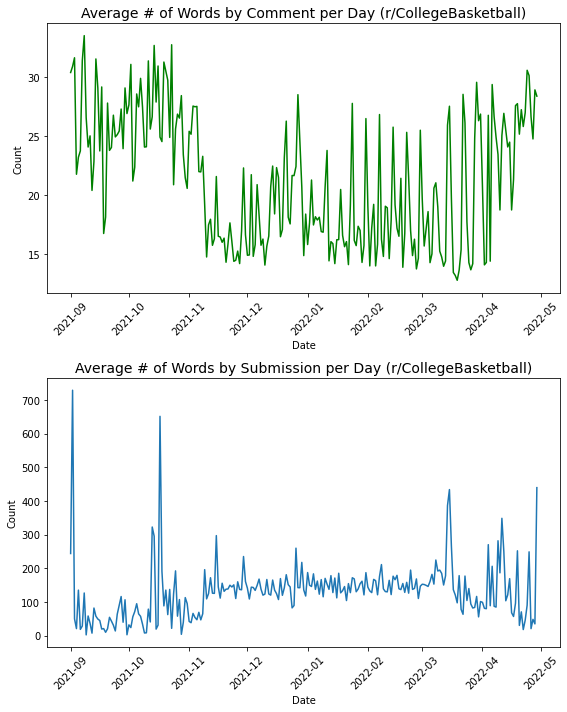

In [18]:
# get average word count by day
t = (
    submissions
    .filter(col("subreddit") == "CollegeBasketball") # keep only college basketball subreddit
    .withColumn("word_count", size(split(col("selftext"), "\\s+"))) # get size of selftext column split by spaces (# of words)
    .groupBy("year", "month", "day")  # group by day
    .agg(avg("word_count").alias("avg_words")) # average number of words per day
)
q = (
    comments
    .filter(col("subreddit") == "CollegeBasketball")  # keep only college basketball subreddit
    .withColumn("word_count", size(split(col("body"), "\\s+"))) # get size of selftext column split by spaces (# of words)
    .groupBy("year", "month", "day")  # group by day
    .agg(avg("word_count").alias("avg_words")) # average number of words per day
)
# convert grouped data to pandas
df_s = t.toPandas()
df = q.toPandas()
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values(by='date') 

df_s['date'] = pd.to_datetime(df_s[['year', 'month', 'day']])
df_s = df_s.sort_values(by='date') 

# Plot average word count by day
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
ax1.plot(df['date'], df['avg_words'], linestyle='-', color = "green")
ax2.plot(df_s['date'], df_s['avg_words'], linestyle='-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Count')
ax1.set_title('Average # of Words by Comment per Day (r/CollegeBasketball)', fontsize = 14)
ax1.tick_params(axis='x', rotation=45)


ax2.set_xlabel('Date')
ax2.set_ylabel('Count')
ax2.set_title('Average # of Words by Submission per Day (r/CollegeBasketball)', fontsize = 14)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

##### Most important words

In [ ]:
# Step 3: Tokenize the text data
tokenizer = Tokenizer(inputCol="text_column", outputCol="words")
df = tokenizer.transform(df)

# Step 4: Calculate Term Frequency (TF)
cv = CountVectorizer(inputCol="words", outputCol="raw_features")
model = cv.fit(df)
df = model.transform(df)

# Step 5: Calculate Inverse Document Frequency (IDF)
idf = IDF(inputCol="raw_features", outputCol="tf_idf_features")
idf_model = idf.fit(df)
df = idf_model.transform(df)

# Now, df contains the TF-IDF features in the "tf_idf_features" column

# Optional: Select relevant columns if needed
result_df = df.select("text_column", "tf_idf_features")

# Show the result
result_df.show(truncate=False)

### Part 3
#### Cleaning Text Data (Comments)

In [27]:
# Text Data Cleaning Pipeline

# covert body of comments data to nlp document format
document_assembler = (
    DocumentAssembler()
    .setInputCol("body")
    .setOutputCol("document")
)
# split document into sentences
sentence = (
    SentenceDetectorDLModel.pretrained("sentence_detector_dl", "en")
    .setInputCols(["document"])
    .setOutputCol("sentence")
)
# tokenize the words in each sentence
tokenizer = (
    Tokenizer()
    .setInputCols(["sentence"])
    .setOutputCol("token")
)
# remove common stopwords
stop_words = (
    StopWordsCleaner().pretrained("stopwords_iso","en")
    .setInputCols(["token"])
    .setOutputCol("cleanTokens")
)
# normalize data (remove any digits or entries that are non-standard words, convert to lowercase)
normalizer = (
    Normalizer()
    .setInputCols(["cleanTokens"])
    .setOutputCol("normalizedTokens")
    .setLowercase(True)
)
# lemmatize the normalized tokens
lemmatizer = (
    LemmatizerModel.pretrained().setInputCols(["normalizedTokens"]).setOutputCol("lemma")
)
# define pipeline
pipeline = Pipeline(stages=[document_assembler, sentence, tokenizer, stop_words, normalizer, lemmatizer])

# fit and transform comments data using the pipeline
model = pipeline.fit(comments)
comments_clean = model.transform(comments)

# print the new clean_text
comments_clean = comments_clean.withColumn("clean_text", col("lemma.result"))
comments_clean.select("clean_text").show()

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 23, 24, Finished, Available)

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
stopwords_iso download started this may take some time.
Approximate size to download 2.1 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 23, 26, Finished, Available)

+--------------------+
|          clean_text|
+--------------------+
|              [fall]|
|[lol, forget, foo...|
|[half, foul, aren...|
|[like, creighton,...|
|  [lose, apparently]|
|[oklahoma, lose, ...|
|[ah, miss, miss, ...|
|[gonna, hour, gam...|
|[miss, shots, ope...|
|   [man, call, ucla]|
|[high, iq, play, ...|
|[yeesh, yeah, fou...|
|               [bet]|
|[northern, iowa, ...|
|[check, busy, foo...|
|          [be, roll]|
|[lmao, im, watch,...|
|      [attaway, cat]|
|[glad, thread, in...|
|      [pretty, cool]|
+--------------------+
only showing top 20 rows



##### Remove comments with less than 5 words

In [30]:
comments_clean = comments_clean.filter(size(col("clean_text")) >= 5)
print("Number of Comments after cleaning", comments_clean.count())

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 23, 27, Finished, Available)

869804

##### Save cleaned comments data

In [32]:

workspace_default_storage_account = "aml6214727930"
workspace_default_container = "azureml-blobstore-6653633b-3460-4381-9199-d9e0f368353c"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)

comments_clean = comments_clean.select('subreddit','author','author_flair_text','body','parent_id','link_id','id','created_utc','supported_team','day','month','year','clean_text')
comments_clean.write.mode("overwrite").parquet(f"{workspace_wasbs_base_url}/basketball_comments_nlp.parquet")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 23, 29, Finished, Available)

#### Cleaning Text Data Submissions

In [34]:
# Text Data Cleaning Pipeline

# covert selftext of submissions data to nlp document format
document_assembler = (
    DocumentAssembler()
    .setInputCol("selftext")
    .setOutputCol("document")
)
# split document into sentences
sentence = (
    SentenceDetectorDLModel.pretrained("sentence_detector_dl", "en")
    .setInputCols(["document"])
    .setOutputCol("sentence")
)
# tokenize the words in each sentence
tokenizer = (
    Tokenizer()
    .setInputCols(["sentence"])
    .setOutputCol("token")
)
# remove common stopwords
stop_words = (
    StopWordsCleaner().pretrained("stopwords_iso","en")
    .setInputCols(["token"])
    .setOutputCol("cleanTokens")
)
# normalize data (remove any digits or entries that are non-standard words, convert to lowercase)
normalizer = (
    Normalizer()
    .setInputCols(["cleanTokens"])
    .setOutputCol("normalizedTokens")
    .setLowercase(True)
)
# lemmatize the normalized tokens
lemmatizer = (
    LemmatizerModel.pretrained().setInputCols(["normalizedTokens"]).setOutputCol("lemma")
)
# define pipeline
pipeline = Pipeline(stages=[document_assembler, sentence, tokenizer, stop_words, normalizer, lemmatizer])

# fit and transform submissions data using the pipeline
model = pipeline.fit(submissions)
submissions_clean = model.transform(submissions)

# print the new clean_text
submissions_clean = submissions_clean.withColumn("clean_text", col("lemma.result"))
submissions_clean.select("clean_text").show()

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 23, 31, Finished, Available)

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
stopwords_iso download started this may take some time.
Approximate size to download 2.1 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 23, 34, Finished, Available)

+--------------------+
|          clean_text|
+--------------------+
|[hello, rcollegeb...|
|[new, game, stupi...|
|[it, free, talk, ...|
|[nebraskafnebrask...|
|[kansas, statefka...|
|[alabamafalabama,...|
|[san, diego, stat...|
|[hello, march, ma...|
|[sorry, hijack, i...|
|[note, purdue, re...|
|[sunday, new, eli...|
|[rankteam, place,...|
|[think, iowa, win...|
|[rank, game, time...|
|[rankings, team, ...|
|[remove, view, po...|
|[texasftexas, sta...|
|[ut, martinfutmar...|
|[ut, arlingtonfut...|
|[smufsmu, new, me...|
+--------------------+
only showing top 20 rows



In [38]:
submissions_clean = submissions_clean.filter(size(col("clean_text")) >= 5)
print("Number of Submissions after cleaning", submissions_clean.count())

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 23, 35, Finished, Available)

9163

##### Saving clean submissions data

In [40]:
submissions_clean = submissions_clean.select('subreddit','author','author_flair_text','title','selftext','created_utc','num_comments','supported_team','game_thread','home_ranking','home_team','away_ranking','away_team','game_time','ranked_matchup','day','month','year','clean_text')
submissions_clean.write.mode("overwrite").parquet(f"{workspace_wasbs_base_url}/basketball_submissions_nlp.parquet")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 23, 37, Finished, Available)

### Part 4: Looking at Top words after cleaning